In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

In [ ]:
!pip install pydub

In [4]:
import pandas as pd
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import tensorflow
from tensorflow import keras
from keras import layers
from keras.layers import (Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, 
                          Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Dropout, LSTM)
from keras.models import Model, load_model
from PIL import Image
import numpy as np
from pydub import AudioSegment
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

In [5]:
genres_musicaux = ['blues','classical','country','disco','hiphop','jazz','metal','pop','reggae','rock']

In [6]:
def add_white_noise(signal, noise_percentage_factor):
    noise = np.random.normal(0, signal.std(), signal.size)
    augmented_signal = signal + noise * noise_percentage_factor
    return augmented_signal

In [7]:
def random_gain(signal, min_factor=0.1, max_factor=0.12):
    gain_rate = np.random.uniform(min_factor, max_factor)
    augmented_signal = signal * gain_rate
    return augmented_signal

In [8]:
def invert_polarity(signal):
    return signal * -1

In [9]:
def get_features():
  labels = []
  features = []
  i = 0
  for g in genres_musicaux:
    print(g)
    for filename in os.listdir(os.path.join('/content/gdrive/MyDrive/Projet Majeure/Premier test/audio3sec/',f'{g}')):
      if not filename.startswith('.'):    #avoiding the .DS_Store file
        path = os.path.join('/content/gdrive/MyDrive/Projet Majeure/Premier test/audio3sec/',f'{g}',f'{filename}')
        signal,sr = librosa.load(path,duration=3)
        white_noise_signal = add_white_noise(signal,0.1)
        gained_signal = random_gain(signal,0.1,0.12)
        inverted_signal = invert_polarity(signal)
        mfcc = np.array(librosa.feature.mfcc(y=signal, sr=sr, n_fft=1012, hop_length=256, n_mfcc=20))
        mfcc_w = np.array(librosa.feature.mfcc(y=white_noise_signal, sr=sr, n_fft=1012, hop_length=256, n_mfcc=20))
        mfcc_g = np.array(librosa.feature.mfcc(y=gained_signal, sr=sr, n_fft=1012, hop_length=256, n_mfcc=20))
        mfcc_i = np.array(librosa.feature.mfcc(y=inverted_signal, sr=sr, n_fft=1012, hop_length=256, n_mfcc=20))
        if len(mfcc[1]) != 259 :      #avoiding some problem of array length
          diff = 259-len(mfcc[1])
          zeros = np.zeros((20,diff))
          mfcc = np.concatenate((mfcc,zeros),axis = 1)
          print(mfcc.shape)
        if len(mfcc_w[1]) != 259 :      #avoiding some problem of array length
          diff = 259-len(mfcc_w[1])
          zeros = np.zeros((20,diff))
          mfcc_w = np.concatenate((mfcc_w,zeros),axis = 1)
          print(mfcc_w.shape)
        if len(mfcc_g[1]) != 259 :      #avoiding some problem of array length
          diff = 259-len(mfcc_g[1])
          zeros = np.zeros((20,diff))
          mfcc_g = np.concatenate((mfcc_g,zeros),axis = 1)
          print(mfcc.shape)
        if len(mfcc_i[1]) != 259 :      #avoiding some problem of array length
          diff = 259-len(mfcc_i[1])
          zeros = np.zeros((20,diff))
          mfcc_i = np.concatenate((mfcc_i,zeros),axis = 1)
          print(mfcc_i.shape)
        features.append(mfcc)
        features.append(mfcc_w)
        features.append(mfcc_g)
        features.append(mfcc_i)
        labels.append(i)
        labels.append(i)
        labels.append(i)
        labels.append(i)
    i += 1
  return(np.array(features), np.array(labels))

In [10]:
X,y = get_features()

blues
classical
(20, 259)
(20, 259)
(20, 259)
(20, 259)
country
(20, 259)
(20, 259)
(20, 259)
(20, 259)
disco
(20, 259)
(20, 259)
(20, 259)
(20, 259)
hiphop
(20, 259)
(20, 259)
(20, 259)
(20, 259)
jazz
metal
pop
reggae
rock


In [11]:
print(X.shape)
print(y.shape)

(39600, 20, 259)
(39600,)


In [12]:
#Split twice to get the validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=123)
#Print the shapes
X_train.shape, X_test.shape, X_val.shape, len(y_train), len(y_test), len(y_val)

((22275, 20, 259), (9900, 20, 259), (7425, 20, 259), 22275, 9900, 7425)

In [13]:
X_train = tensorflow.expand_dims(X_train, axis = -1)     #expansion for convolution
X_test = tensorflow.expand_dims(X_test, axis = -1)     #expansion for convolution
X_val = tensorflow.expand_dims(X_val, axis = -1)     #expansion for convolution

print('Expand_dims shape', X_train.shape, X_test.shape, X_val.shape)

Expand_dims shape (22275, 20, 259, 1) (9900, 20, 259, 1) (7425, 20, 259, 1)


In [14]:
input_shape=(20,259,1)

In [15]:
model = keras.Sequential()
model.add(Conv2D(32,kernel_size=(3,3),strides = (1,1),activation='relu', input_shape=input_shape))
model.add(BatchNormalization(axis=3))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64,kernel_size=(3,3),strides = (1,1),activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(128,kernel_size=(3,3),strides = (1,1),activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Flatten())
model.add(Dropout(rate=0.3))
model.add(Dense(10, activation='softmax'))

In [17]:
model.compile(optimizer='rmsprop',loss=tensorflow.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [18]:
history = model.fit(X_train, y_train, batch_size = 1485, epochs=50, validation_data= (X_val, y_val))

Epoch 1/50
15/15 [==============================] - 221s 15s/step - loss: 2.2485 - accuracy: 0.3815 - val_loss: 7.8364 - val_accuracy: 0.1453
Epoch 2/50
15/15 [==============================] - 214s 14s/step - loss: 1.3070 - accuracy: 0.5702 - val_loss: 5.8143 - val_accuracy: 0.1620
Epoch 3/50
15/15 [==============================] - 221s 15s/step - loss: 1.0223 - accuracy: 0.6527 - val_loss: 3.9468 - val_accuracy: 0.1892
Epoch 4/50
15/15 [==============================] - 216s 15s/step - loss: 0.8686 - accuracy: 0.7041 - val_loss: 2.6224 - val_accuracy: 0.3195
Epoch 5/50
15/15 [==============================] - 215s 14s/step - loss: 0.6745 - accuracy: 0.7692 - val_loss: 2.1736 - val_accuracy: 0.3374
Epoch 6/50
15/15 [==============================] - 219s 15s/step - loss: 0.5851 - accuracy: 0.7997 - val_loss: 1.5028 - val_accuracy: 0.4672
Epoch 7/50
15/15 [==============================] - 215s 14s/step - loss: 0.5000 - accuracy: 0.8305 - val_loss: 1.3230 - val_accuracy: 0.5030
Epoch 

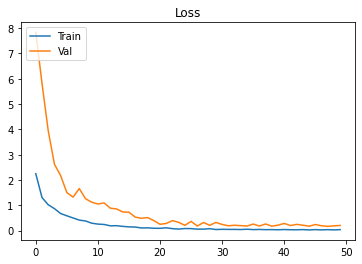

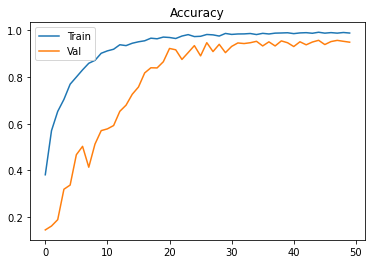

In [19]:
loss_curve = history.history["loss"]
acc_curve = history.history["accuracy"]

loss_val_curve = history.history["val_loss"]
acc_val_curve = history.history["val_accuracy"]

plt.plot(loss_curve, label="Train")
plt.plot(loss_val_curve, label="Val")
plt.legend(loc='upper left')
plt.title("Loss")
plt.show()

plt.plot(acc_curve, label="Train")
plt.plot(acc_val_curve, label="Val")
plt.legend(loc='upper left')
plt.title("Accuracy")
plt.show()

In [20]:
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tensorflow.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

310/310 [==============================] - 25s 79ms/step
Confusion_matrix:  tf.Tensor(
[[899   4  14  18   0  25   3   2   3  22]
 [  0 982   1   0   0   7   0   0   0   0]
 [  1   6 944  13   0  21   1   0   1   3]
 [  0   0   5 976   0   0   3   3   1   2]
 [  2   0   5  22 920   5  17   0  12   7]
 [  1  15   5   0   0 966   0   0   0   3]
 [  3   0   2   5   1   0 957   0   0  22]
 [  0   5   6  15  11   4   0 932   3  14]
 [  3   2   3  15   5   6   2   6 943   5]
 [  1  11  20  24   0  11  15   5   5 898]], shape=(10, 10), dtype=int32)


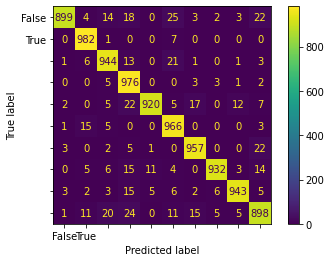

In [21]:
confusion_matrix = metrics.confusion_matrix(y_test, np.argmax(y_pred,axis=1))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

In [22]:
model.save('/content/gdrive/MyDrive/MFCCAudioAugmentationV3')

In [ ]:
StrtMin = 1
StrtSec = 0

EndMin = 1
EndSec = 40

# Time to milliseconds conversion
StrtTime = StrtMin*60*1000+StrtSec*1000
EndTime = StrtMin*60*1000+EndSec*1000

In [ ]:
audio = AudioSegment.from_wav("/content/gdrive/MyDrive/test song/Miss You (Oliver Tree) (Sped Up Version)-Bk6Fjv9ruM4.wav")
newAudio = audio[StrtTime:EndTime]
newAudio.export('/content/song.wav', format='wav')

for w in range(0,10):
          t1 = 3*(w)*1000
          t2 = 3*(w+1)*1000
          newAudio = AudioSegment.from_wav('/content/song.wav')
          new = newAudio[t1:t2]
          new.export(f'/content/{str(w)}.wav', format='wav')

In [ ]:
classe = []

for i in range(0,10):
  y,sr = librosa.load(f'{str(w)}.wav',duration=3)
  data = np.array([librosa.feature.mfcc(y=y,sr=sr, n_fft=1012, hop_length=256, n_mfcc=20)])


  data = tensorflow.expand_dims(data, axis = -1)
  prediction = model.predict(data)
  class_label = np.argmax(prediction)
  print(class_label)
  classe.append(class_label)

moyenne = int(sum(classe)/len(classe))
print(genres_musicaux[moyenne])

1/1 [==============================] - 0s 29ms/step
3
1/1 [==============================] - 0s 26ms/step
3
1/1 [==============================] - 0s 26ms/step
3
1/1 [==============================] - 0s 26ms/step
3
1/1 [==============================] - 0s 26ms/step
3
1/1 [==============================] - 0s 28ms/step
3
1/1 [==============================] - 0s 31ms/step
3
1/1 [==============================] - 0s 36ms/step
3
1/1 [==============================] - 0s 27ms/step
3
1/1 [==============================] - 0s 30ms/step
3
disco
